In [5]:
import os
import sys

sys.path.append(os.path.abspath('../..'))
from sfl.config import FLConfig
import argparse

config = FLConfig(
    collect_intermediates=False,
    global_round=10,
    client_evaluate_freq=500,
    client_epoch=1,  # 每轮联邦每个Client训2轮
    split_point_1=6,
    split_point_2=30,  # [0,1 | 2,3,.... 29| 30, 31]
    use_lora_at_trunk=True,  # 在trunk部分使用LoRA
    use_lora_at_top=True,
    use_lora_at_bottom=False,
    top_and_bottom_from_scratch='True',
    attack_mode='b2tr',
    client_steps=700
)

args = {
    'dataset_train_frac': 1.0,
    'dataset_test_frac': 0.1,
    'dataset': 'piqa',
    'model_name': 'llama2',
    'save_checkpoint': True,
    'task_type': 'lm',
    'attacker_freq': 10,
    'attacker_samples':2,
    'log_to_wandb': False
}
# convert to namespace
args = argparse.Namespace(**args)

ModuleNotFoundError: No module named 'sfl'

In [1]:
from sfl.config import DRAConfig
from sfl.utils.exp import get_dra_attacker

atk_cfg = DRAConfig(target_model_name='llama2', target_dataset='sanitized', target_sps='6-6', train_label='val', target_model_load_bits=4)
atk, _ = get_dra_attacker(atk_cfg)

ModuleNotFoundError: No module named 'sfl'

In [ ]:

from transformers import AdamW
from sfl.utils.model import evaluate_attacker_rouge
from sfl.utils.exp import get_dataset_class
from tqdm import tqdm_notebook

client_ids = ['0']

dataset_cls = get_dataset_class('sanitized')
dataset = dataset_cls(tokenizer=tokenizer, client_ids=client_ids)
test_loader = dataset.get_dataloader_unsliced(2, 'train', shrink_frac=0.2)

avg_rouge = 0
avg_rouge_dlg = 0
step = 0
opt = AdamW(model.parameters(), lr=1e-5)
config.noise_mode = 'dxp'
config.noise_scale = 1000.0
model.config_sfl(config)

dlg.to(model.device)
atk.to(model.device)
with tqdm_notebook(total=len(test_loader)) as pbar:
  for batch in test_loader:
    opt.zero_grad()
    input_ids = batch['input_ids'].to(model.device)
    o1 = model(input_ids, batch['input_att_mask'].to(model.device), labels=input_ids)
    # o2 = dlg(tr2t.fx.to(model.device))
    # print(o1)
    o1.loss.backward()
    b2tr, tr2t, all = model.get_all_inter()
    opt.step()
    pred = atk(b2tr.fx.to(model.device))
    # print(batch['input_text'][0])
    gt = dlg.fit(tr2t.fx.to(model.device), tr2t.grad.to(model.device), epochs=20, gt_init=pred)
    # gt_texts = [tokenizer.decode(g.argmax(-1), skip_special_tokens=True) for g in gt]
    avg_rouge += evaluate_attacker_rouge(tokenizer, pred, batch)['rouge-l']['f']
    avg_rouge_dlg += evaluate_attacker_rouge(tokenizer, gt, batch)['rouge-l']['f']
    step += 1
    pbar.set_postfix({'dra_rouge': avg_rouge / step, 'dlg_rouge':avg_rouge_dlg/step})
    pbar.update()


In [ ]:
from sfl.utils.exp import add_sfl_params
import argparse
from typing import Any
from sfl.utils.model import Intermediate
from sfl.simulator.strategy import BaseSFLStrategy
from sfl.simulator.simulator import SFLSimulator

parser = argparse.ArgumentParser()
add_sfl_params(parser)
args = parser.parse_args({})

args.log_to_wandb = False
args.dlg_epochs = 30
args.dlg_init_with_dra = True

# 定义Client本地学习策略
class QAFLStrategy(BaseSFLStrategy):


    def sample_attacker_triggered(self, global_round, client_id, local_epoch, local_step,
                                  b2tr_inter: Intermediate, tr2t_inter: Intermediate,
                                  all_inter: dict[Any, Intermediate],
                                  batch, logs):
        encoder_inter = all_inter.get('encoder', None)
        with torch.no_grad():
            for type, atk in zip(['b2tr', 'tr2t'], [self.dra1, self.dra2]):
                if atk is None:
                    continue
                atk.to(self.simulator.device)
                inter = b2tr_inter if type == 'b2tr' else tr2t_inter
                if self.llm.type == 'encoder-decoder':
                    attacked = atk(torch.concat([encoder_inter.fx.to(
                        self.simulator.device), inter.fx.to(atk.device)], dim=1))
                else:
                    attacked = atk(inter.fx.to(atk.device))
                rouge_res = calculate_rouge(self.tokenizer, attacked, batch['input_text'])
                self.log_to_sample_result(client_id, f'attacker_{type}', rouge_res['rouge-l']['f'])
                self.log_to_all_result(client_id, f'attacker_{type}', rouge_res['rouge-l']['f'])
                logs[f'attacker_{type}_step'] = rouge_res['rouge-l']['f']
        gt_init = None
        if self.args.dlg_init_with_dra:
            gt_init = attacked
        self.dlg.to(self.simulator.device)
        gt = self.dlg.fit(tr2t_inter.fx.to(self.simulator.device), tr2t_inter.grad.to(self.simulator.device),
                          epochs=self.args.dlg_epochs,
                          adjust=False,
                          beta=self.args.dlg_beta,
                          gt_init=gt_init,
                          gt_reg=self.args.dlg_dra_reg,
                          temp_range=self.args.dlg_temp_range,
                          further_ft=self.args.dlg_further_ft,
                          encoder_inter=None if encoder_inter is None else encoder_inter.fx.to(
                              self.simulator.device)
                          )
        if self.llm.type == 'encoder-decoder':
            # replace the latter half of attacked to gt
            attacked[:, -gt.shape[1]:, :] = gt
            rouge = calculate_rouge(self.tokenizer, attacked, batch['input_text'])
        else:
            rouge = calculate_rouge(self.tokenizer, gt, batch['input_text'])
        self.log_to_sample_result(client_id, 'tag_rouge_lf', rouge['rouge-l']['f'])
        self.log_to_all_result(client_id, 'tag_rouge_lf', rouge['rouge-l']['f'])
        print(self.attack_all_performs)



simulator = SFLSimulator(client_ids=client_ids,
                             strategy=QAFLStrategy(args, model, tokenizer, test_loader, atk, None,dlg),
                             llm=model,
                             tokenizer=tokenizer,
                             dataset=dataset, config=config, args=args)

In [ ]:
simulator.simulate()

# 生成SensMarked数据集

In [7]:
import pandas as pd
raw = pd.read_csv('/home/project/SFL-LLM/sanitized_data.csv')

In [8]:
raw

,sani_label,sani_label_trans,entity,content,sani_gpt4,sani_gpt4_trans,gpt4_trans
0,<PERSON> attended the press conference to rais...,<PERSON>参加了新闻发布会，他对比赛官员<PERSON>提出了关切，而不是派遣教练<P...,"['Chris Kendall', 'Widnes', 'today', 'Monday',...",Beaumont attended the press conference to rais...,John Smith attended the press conference to ra...,约翰·史密斯参加了新闻发布会，向比赛官员迈克·约翰逊表达了他对比赛失利的担忧，而不是派遣教练...,博蒙特参加了新闻发布会，向比赛官员克里斯·肯德尔表达了他对比赛失利的担忧，而不是派遣教练尼尔...
1,"The <DATE>, who joined from <ORG> for £<MONEY>...",这位于<DATE>从<ORG>以£<MONEY>的价格加盟的球员，曾在<DATE>为<ORG...,"['Derby', 'a great season', '3', 'Curtis Davie...","The 24-year-old, who joined from Liverpool for...","The 30-year-old, who joined from Manchester fo...",这位30岁的球员上周以700万英镑的价格从曼彻斯特加盟，他在2018-2019赛季为公牛队出...,这位24岁的球员上个月以300万英镑的价格从利物浦加盟，他在2013-2014赛季为公羊队出...
2,<ORG> slipped to 47-4 but <PERSON> led a recov...,<ORG>滑到了47-4，但<PERSON>以96分不出的成绩带领球队恢复了局面。<PERS...,"['Lewis Hill', 'Leicestershire', 'Ned Eckersle...",Derbyshire slipped to 47-4 but Alex Hughes led...,Yorkshire slipped to 47-4 but John Smith led a...,约克郡队在比赛中一度陷入47-4的困境，但约翰·史密斯以96分不出的表现带领球队实现了反弹。...,德比郡队在比赛中一度陷入47-4的困境，但亚历克斯·休斯以96分不出的表现带领球队实现了反弹...
3,<ORG> have agreed a deal to loan <NORP> inter...,<ORG>已经同意将<NORP>国际后卫<PERSON>租借给陷入困境的<ORG>，俱乐部已...,"['Spartak Moscow', 'Italian', 'Milan', 'Sparta...",Spartak Moscow have agreed a deal to loan Ita...,Barcelona FC have agreed a deal to loan Spanis...,巴塞罗那足球俱乐部已经同意将西班牙国家队后卫亚历杭德罗·费尔南德斯租借给陷入困境的皇家马德里...,莫斯科斯巴达克同意将意大利国家队后卫萨尔瓦托雷·博凯蒂租借给陷入困境的AC米兰，俱乐部已经确...
4,The <DATE> announced the ban after scoring in ...,<DATE>在<PERSON>在球队3-0的世界杯预选赛胜利后得分后宣布了禁令。一份广播报道...,"['Argentina', 'Colombia', 'Lavezzi', 'Ezequiel...",The 29-year-old announced the ban after scorin...,The 35-year-old announced the ban after scorin...,这位35岁的球员在秘鲁队以3-0的比分赢得世界杯预选赛后宣布禁赛。一则广播报道声称前锋卡洛斯...,这位29岁的球员在哥伦比亚队以3-0的比分赢得世界杯预选赛后宣布禁赛。一则广播报道声称前锋埃...
...,...,...,...,...,...,...,...
19660,The <NORP> champions take on the <NORP> in <GP...,<NORP>冠军将在<GPE>的比赛中迎战<NORP>，他们希望能够锁定一个晋级八强的名额。...,"['South Korea', 'Africa', 'Costa Rica', '[Jurg...",The African champions take on the Europeans in...,The Asian champions take on the Americans in T...,亚洲冠军将在日本东京与美国队对决，他们希望能够锁定一个晋级四分之一决赛的名额。村上（Mura...,非洲冠军将在韩国济州岛与欧洲队对决，他们希望能够锁定一个晋级四分之一决赛的名额。钱贝西（Ch...
19661,(<ORG>) -- He's the king of cool but <GPE> sno...,(<ORG>) - 他是酷的王者，但<GPE>滑雪板明星<PERSON>不会在索契<DATE...,"['Norway', 'Team USA', 'Finnish', 'U.S.', 'Tue...",(CNN) -- He's the king of cool but U.S. snowbo...,(BBC) -- He's the emperor of cool but Canadian...,（BBC）-- 他是酷劲十足的皇帝，但加拿大滑雪板明星约翰·多伊将不会在东京2020年的令人...,（CNN）-- 他是酷劲十足的国际滑雪板明星肖恩·怀特，但他将不会在索契2014年的令人生畏...
19662,"<PERSON>, <DATE>, is a doubt for <ORG>' Six Na...",<PERSON>，<DATE>，在对阵<GPE>的六国赛比赛中因脚踝受伤而一瘸一拐地离场。在...,"['Sunday', 'Wales', 'Priestland', 'Ireland', '...","Biggar, 26, is a doubt for Wales' Six Nations ...","Hudson, 32, is a doubt for France's Six Nation...",Hudson，32岁，在对阵西班牙的比赛中因脚踝受伤而退出，成为法国对阵意大利的六国赛比赛的...,Biggar，26岁，在对阵爱尔兰的比赛中因脚踝受伤而退出，成为威尔士对阵苏格兰的六国赛比赛...
19663,(CNN)Eight crew members are missing after a ca...,(CNN)据<ORG>报道，一艘货船在<GPE>海岸翻覆后，8名船员失踪。<ORG>表示，搜...,"['Sunday', 'England', 'RNLI', 'Southampton', '...",(CNN)Eight crew members are missing after a ca...,(CNN)Eight crew members are missing after a ca...,（CNN）国际海上救援联合会周五早上表示，一艘货船在爱尔兰海岸翻覆后，有八名船员失踪。海军和...,（CNN）周六晚间，英国皇家国家救生艇机构表示，一艘货船在苏格兰海岸翻覆后，有八名船员失踪。...


In [13]:
import re
import ast
from tqdm import tqdm_notebook

import pandas as pd
raw = pd.read_csv('/home/project/SFL-LLM/sanitized_data.csv')
# take only 'content' and 'entity'
raw = raw[['content', 'entity', 'sani_gpt4','sani_label']]


marked_content = []

for i, row in tqdm_notebook(raw.iterrows(), total=len(raw)):
    # get the content and entity
    data = {}
    content = row['content']
    entity = row['entity']
    data['sentence'] = content
    # print(entity)
    entity = ast.literal_eval(entity)
    replaced_places = []
    for e in entity:
        indexes = [(m.start(), m.end()) for m in re.finditer(re.escape(e), content)]
        for idx in indexes:
            if any([idx[0] > r[0] and idx[1] < r[1] for r in replaced_places]):
                continue
            content = content[:idx[0]] + '<P>' + content[idx[0]:idx[1]] + '<\P>' + content[idx[1]:]
            replaced_places.append(idx)
    marked_content.append(content)

df = pd.DataFrame(marked_content, columns=['marked_content'])
new = pd.concat([raw, df], axis=1)

/tmp/ipykernel_548089/1355228985.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(raw.iterrows(), total=len(raw)):


  0%|          | 0/19665 [00:00<?, ?it/s]

In [14]:
# split the dataset
type_labels = ['train'] * len(new)
# randomly select 20% indexes
all_indexes = list(range(len(new)))
import random

test_indexes = random.sample(all_indexes, int(len(new) * 0.25))
for i in test_indexes:
    type_labels[i] = 'test'

all_indexes = list(set(all_indexes) - set(test_indexes))
val_indexes = random.sample(all_indexes, int(len(new) * 0.15))
for i in val_indexes:
    type_labels[i] = 'validation'

# make type_labels to dataframe and concat it with the original dataframe
df = pd.DataFrame(type_labels, columns=['type'])
# concat it with new
new = pd.concat([new, df], axis=1)

In [16]:
new.to_csv('/home/project/SFL-LLM/sensi.csv', index=False)

,content,entity,sani_gpt4,sani_label,marked_content,type
0,Beaumont attended the press conference to rais...,"['Chris Kendall', 'Widnes', 'today', 'Monday',...",John Smith attended the press conference to ra...,<PERSON> attended the press conference to rais...,<P>Beaumont<\P> attended the press conference ...,train
1,"The 24-year-old, who joined from Liverpool for...","['Derby', 'a great season', '3', 'Curtis Davie...","The 30-year-old, who joined from Manchester fo...","The <DATE>, who joined from <ORG> for £<MONEY>...","The <P>24-year-old<\P>, who joined from <P>Liv...",test
2,Derbyshire slipped to 47-4 but Alex Hughes led...,"['Lewis Hill', 'Leicestershire', 'Ned Eckersle...",Yorkshire slipped to 47-4 but John Smith led a...,<ORG> slipped to 47-4 but <PERSON> led a recov...,<P>Derbyshire<\P> slipped to 47-4 but Alex <P>...,train
3,Spartak Moscow have agreed a deal to loan Ita...,"['Spartak Moscow', 'Italian', 'Milan', 'Sparta...",Barcelona FC have agreed a deal to loan Spanis...,<ORG> have agreed a deal to loan <NORP> inter...,<P>Spartak Moscow<\P> have agreed a deal to l...,train
4,The 29-year-old announced the ban after scorin...,"['Argentina', 'Colombia', 'Lavezzi', 'Ezequiel...",The 35-year-old announced the ban after scorin...,The <DATE> announced the ban after scoring in ...,The <P>29-year-old<\P> announced the ban after...,validation
...,...,...,...,...,...,...
19660,The African champions take on the Europeans in...,"['South Korea', 'Africa', 'Costa Rica', '[Jurg...",The Asian champions take on the Americans in T...,The <NORP> champions take on the <NORP> in <GP...,The <P>Africa<\P>n champions take on the <P>Eu...,train
19661,(CNN) -- He's the king of cool but U.S. snowbo...,"['Norway', 'Team USA', 'Finnish', 'U.S.', 'Tue...",(BBC) -- He's the emperor of cool but Canadian...,(<ORG>) -- He's the king of cool but <GPE> sno...,(<P>CNN<\P>) -- He's the king of cool but <P>U...,test
19662,"Biggar, 26, is a doubt for Wales' Six Nations ...","['Sunday', 'Wales', 'Priestland', 'Ireland', '...","Hudson, 32, is a doubt for France's Six Nation...","<PERSON>, <DATE>, is a doubt for <ORG>' Six Na...","<P>Biggar<\P>, <P>26<\P>, is a doubt for <P>Wa...",test
19663,(CNN)Eight crew members are missing after a ca...,"['Sunday', 'England', 'RNLI', 'Southampton', '...",(CNN)Eight crew members are missing after a ca...,(CNN)Eight crew members are missing after a ca...,(CNN)Eight crew members are missing after a ca...,train


In [ ]:


from datasets import Dataset



dataset = Dataset.from_pandas(new)

In [5]:
import sys
import os
sys.path.append(os.path.abspath('../..'))

# _, tokenizer = get_model_and_tokenizer('bert')
# model, t = get_model_and_tokenizer('flan-t5-large')

In [ ]:

from sfl.simulator.dataset import FedDataset


class SanitizedFedDataset(FedDataset):

    def _format(self, example):
        return {'input': example['content'], 'entities': ast.literal_eval(example['entity'])}

    def _col_fun(self, batch):
        texts = [b['input'] for b in batch]
        input = self.tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        mask = torch.zeros_like(input['input_ids'])
        for sp, sample in enumerate(batch):
            seq = input['input_ids'][sp].numpy().tolist()
            r = tokenizer(sample['entities'], add_special_tokens=False)
            for subseq in r.input_ids:
                for i in range(len(seq) - len(subseq) + 1):
                    if seq[i:i + len(subseq)] == subseq:
                        mask[sp, i:i + len(subseq)] = 1

        return {'input_ids': input['input_ids'],
                'input_att_mask': input['attention_mask'],
                'input_text': texts, 'entities': [b['entity'] for b in batch],
                'input_santi_mask': mask}

    def __init__(self, tokenizer, client_ids: list[str], ):
        self.df = pd.read_csv('/home/project/SFL-LLM/sanitized_data_marked.csv')
        dataset = {
            'train': Dataset.from_pandas(self.df[self.df['type'] == 'train']),
            'val': Dataset.from_pandas(self.df[self.df['type'] == 'val']),
            'test': Dataset.from_pandas(self.df[self.df['type'] == 'test'])
        }
        super().__init__(tokenizer, client_ids, dataset, ['train', 'val', 'test'])


ds = SanitizedFedDataset(tokenizer, ['0'])

In [ ]:
ld = ds.get_dataloader_unsliced(6, 'val')

In [ ]:

for batch in ld:
    # find input_ids masked by mask
    input_ids = batch['input_ids']
    mask = batch['input_santi_mask']
    masked = input_ids * mask

    print(tokenizer.decode(masked[0],skip_special_tokens=True))
    print(batch['entities'][0])
    break

In [1]:
import os
import sys

sys.path.append(os.path.abspath('../..'))
from sfl.config import FLConfig
from sfl.utils.exp import get_model_and_tokenizer
import argparse

config = FLConfig(
    collect_intermediates=False,
    global_round=10,
    client_evaluate_freq=500,
    client_epoch=1,  # 每轮联邦每个Client训2轮
    split_point_1=6,
    split_point_2=30,  # [0,1 | 2,3,.... 29| 30, 31]
    use_lora_at_trunk=True,  # 在trunk部分使用LoRA
    use_lora_at_top=True,
    use_lora_at_bottom=False,
    top_and_bottom_from_scratch='True',
    attack_mode='b2tr',
    client_steps=700
)

args = {
    'dataset_train_frac': 1.0,
    'dataset_test_frac': 0.1,
    'dataset': 'piqa',
    'model_name': 'gpt2-large',
    'save_checkpoint': True,
    'task_type': 'lm',
    'attacker_freq': 10000,
    'log_to_wandb': False
}
# convert to namespace
args = argparse.Namespace(**args)

ModuleNotFoundError: No module named 'sfl'

In [2]:
model, tokenizer = get_model_and_tokenizer(args.model_name)
model.config_sfl(config)

In [18]:
model, tok = get_model_and_tokenizer('llama2')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
model.config

LlamaConfig {
  "_name_or_path": "/root/autodl-tmp/sfl/models/daryl149/llama-2-7b-chat-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": false,
    "load_in_8bit": true
  },
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.31.0",
  "use_cache": true,
  "vo

In [3]:
from sfl.utils.exp import get_dataset
from sfl.config import DRA_train_label, DRA_test_label

dataset = get_dataset(args.dataset, tokenizer,client_ids=['0'],shrink_frac=0.08)
pub_loader = dataset.get_dataloader_unsliced(16, DRA_train_label[args.dataset], args.dataset_train_frac)
test_loader = dataset.get_dataloader_unsliced(16, DRA_test_label[args.dataset], args.dataset_test_frac)

In [4]:

from sfl.utils.model import get_best_gpu
from sfl.model.attacker.fsha_attacker import FSHAAttacker, AutoEncoderConfig

device = get_best_gpu()
model.to(device)
attacker = FSHAAttacker(AutoEncoderConfig(), target_config=model.config)
attacker.to(model.device)
# attacker.fit_auto_encoder(model, tokenizer,pub_loader,test_loader, 50, args)

FSHAAttacker(
  (f_inv): GRUDRAttacker(
    (gru): GRU(1280, 256, batch_first=True)
    (mlp): Linear(in_features=256, out_features=50257, bias=True)
  )
  (f): GRUDRAttacker(
    (gru): GRU(50257, 256, batch_first=True)
    (mlp): Linear(in_features=256, out_features=1280, bias=True)
  )
  (d): GRU(1280, 256, batch_first=True)
  (d_mlp): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [5]:


# from sfl.utils.exp import get_fsha_attacker, DRAConfig
#
# attacker = get_fsha_attacker(DRAConfig(b2tr_sp=6,target_model_name='gpt2-large',target_sps='6-6', train_label='validation',dataset='piqa'))

In [9]:

from sfl.simulator.simulator import SFLSimulator
from sfl.utils.model import get_t5_input, calc_unshift_loss
from sfl.model.attacker.fsha_attacker import FSHAAttacker
from torch.utils.data import DataLoader
from typing import Iterator
from sfl.model.llm.split_model import SplitWrapperModel
from sfl.simulator.strategy import BaseSFLStrategy
from torch.optim import Adam
from sfl.utils.model import calculate_rouge


class FSHAStrategy(BaseSFLStrategy):

    def __init__(self, args, llm, tokenizer, attacker: FSHAAttacker, pub_loader: DataLoader):
        super().__init__(args, llm, tokenizer)
        self.attacker = attacker
        self.pub_loader = pub_loader
        self.pub_loader_iter = iter(pub_loader)
        self.optim_d = Adam(list(self.attacker.d_mlp.parameters())+list(self.attacker.d.parameters()),lr=1e-5, weight_decay=1e-6)
        self.optim_f = Adam(list(self.attacker.f.parameters())+list(self.attacker.f_inv.parameters()),lr=1e-4, weight_decay=1e-5)

    def client_step(self, client_id: str, global_round, client_epoch, llm: SplitWrapperModel, iterator: Iterator,
                    config: FLConfig):
        optimizer = Adam([p for _, p in llm.get_top_params()], lr=5e-7, weight_decay=1e-7)
        # optimizer = AdamW([p for _, p in llm.get_top_params()], lr=3e-7, weight_decay=1e-4)
        avg_d_loss = 0
        avg_f_loss = 0
        avg_rouge_lf = 0
        batch_num = 0
        with tqdm_notebook(total=config.client_steps) as pbar:
            for step, batch in enumerate(iterator):
                if llm.type == 'encoder-decoder':
                    outputs = llm(**get_t5_input(batch, self.tokenizer, llm.device))
                else:
                    input_ids = batch['input_ids'].to(llm.device)
                    attention_mask = batch['input_att_mask'].to(llm.device)
                    labels = input_ids
                    if 'labels' in batch and self.task_type == 'clsf':
                        labels = batch['labels'].to(llm.device)
                    outputs = llm(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
                z_priv = outputs
                try:
                    x_pub = next(self.pub_loader_iter)
                except StopIteration:
                    self.pub_loader_iter = iter(self.pub_loader)
                    x_pub = next(self.pub_loader_iter)
                x_pub = x_pub['input_ids'].to(llm.device)
                z_pub = self.attacker.f_forward(x_pub)
                adv_priv_logits = self.attacker.d_forward(z_priv)
                adv_pub_logits = self.attacker.d_forward(z_pub)
                # print('pub', adv_pub_logits, 'priv', adv_priv_logits)

                # f_loss = torch.mean(adv_priv_logits)
                f_loss = torch.mean(
                    torch.binary_cross_entropy_with_logits(adv_priv_logits, torch.ones_like(adv_priv_logits)))

                d_loss_true = torch.mean(
                    torch.binary_cross_entropy_with_logits(adv_pub_logits, torch.ones_like(adv_pub_logits)
                                                           ))
                d_loss_fake = torch.mean(
                    torch.binary_cross_entropy_with_logits(adv_priv_logits, torch.zeros_like(adv_priv_logits)))
                d_loss = (d_loss_true + d_loss_fake) / 2
                # d_loss_true = torch.mean(adv_pub_logits)
                # d_loss_fake = -torch.mean(adv_priv_logits)
                # # print(d_loss_true, d_loss_fake)
                # d_loss = d_loss_true + d_loss_fake
                rec_x_pub = self.attacker.f_inv_forward(z_pub)
                inv_loss = calc_unshift_loss(rec_x_pub, x_pub)

                rec_x_priv = self.attacker.f_inv_forward(z_priv)
                recover_rouge = calculate_rouge(self.tokenizer, rec_x_priv, batch['input_text'])
                avg_rouge_lf += recover_rouge['rouge-l']['f']

                # (d_loss+f_loss).backward()
                self.optim_d.zero_grad()
                self.optim_f.zero_grad()
                (inv_loss+d_loss).backward(retain_graph=True)
                self.optim_d.step()
                self.optim_f.step()

                optimizer.zero_grad()
                f_grad = torch.autograd.grad(f_loss, z_priv)[0]
                z_priv.backward(f_grad)
                optimizer.step()
                # optimizer.step()

                batch_num += 1
                avg_d_loss += d_loss.detach().cpu().item()
                avg_f_loss += f_loss.detach().cpu().item()
                pbar.set_description(
                    f'Client {client_id} HIJACK Epoch {client_epoch} Step {self.simulator.get_current_step(client_id, step)} D_Loss {d_loss.item():.3f}, F_Loss {f_loss.item():.3f}, Rouge_L_F {recover_rouge["rouge-l"]["f"]:.3f}, Avg_Rouge_L_F {avg_rouge_lf / (step + 1):.3f}')
                self.step_done(client_id, step, batch,
                               {"d_loss": float(avg_d_loss / batch_num),
                                "f_loss": float(avg_f_loss / batch_num),
                                "rouge_l_f": float(avg_rouge_lf / batch_num),
                                })
                pbar.update(1)


attacker.to(model.device)
attacker.train()
simulator = SFLSimulator(client_ids=['0'],
                         strategy=FSHAStrategy(args, model, tokenizer, attacker, pub_loader),
                         llm=model,
                         tokenizer=tokenizer,
                         dataset=dataset, config=config, args=args)

simulator.simulate()

NameError: name 'FLConfig' is not defined

In [2]:
import os
import sys
sys.path.append(os.path.abspath('../'))
from sfl.utils.exp import get_model_and_tokenizer
from sfl.config import FLConfig
from sfl.utils.model import get_best_gpu

model, processor = get_model_and_tokenizer('vit-large')

device = get_best_gpu()
model.to(device)
config = FLConfig(
    collect_intermediates=False,
    global_round=10,
    client_evaluate_freq=500,
    client_epoch=1,  # 每轮联邦每个Client训2轮
    split_point_1=6,
    split_point_2=20,  # [0,1 | 2,3,.... 29| 30, 31]
    use_lora_at_trunk=False,  # 在trunk部分使用LoRA
    use_lora_at_top=False,
    use_lora_at_bottom=False,
    top_and_bottom_from_scratch='True',
    attack_mode='b2tr',
    client_steps=700
)

model.config_sfl(config, None)

In [3]:
model

ViTForImageClassificationSplit(
  (vit): ViTSplit(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoderSplit(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): L

In [2]:
from sfl.utils.exp import get_dataset

ds = get_dataset('imagewoof',processor, client_ids=['0'], shrink_frac=0.1)
dl = ds.get_dataloader_unsliced(64,'train', 1.0)

/root/miniconda3/envs/sfl/lib/python3.11/site-packages/datasets/load.py:926: FutureWarning: The repository for imagewoof contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /root/autodl-tmp/sfl/datasets/imagewoof/imagewoof.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
from sfl.model.attacker.dra_attacker import ViTDRAttacker
from sfl.model.attacker.dra_attacker import ViTDRAttackerConfig

attacker = ViTDRAttacker(ViTDRAttackerConfig(), model.config)

In [4]:
from sfl.utils.model import convert_to_image
# train the attacker
import torch
import torch.optim as optim
from tqdm import tqdm_notebook

# attacker.to(device)

def test(md, atk, image):
    atk.to(md.device)
    inter = md(image['input'].to(model.device))
    image = convert_to_image(atk(inter))
    image[0].show()

In [5]:
optimizer = optim.AdamW(attacker.parameters(), lr=1e-3, weight_decay=1e-5)

epochs = 10

with tqdm_notebook(total=epochs*len(dl)) as pbar:
    step = 0
    for epc in range(epochs):
        for batch in dl:
            input_tensor = batch['input'].to(device)
            inter = model(input_tensor)
            recovered = attacker(inter)
            loss = torch.nn.functional.mse_loss(recovered, input_tensor)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pbar.set_description(f'Epoch {epc} Step {step} Loss {loss.item()}')
            pbar.update(1)
            step += 1
            # if step % 100 == 0:
            #     test(model, attacker, sample)


/tmp/ipykernel_195557/4195046156.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=epochs*len(dl)) as pbar:


  0%|          | 0/1420 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:

from sfl.utils.exp import get_dra_attacker, DRAConfig

atk, _ = get_dra_attacker(
    DRAConfig(target_model_name='vit', larger_better=False, target_sps='6-999', train_label='validation',
              dataset='imagewoof', model='vit', tr2t_enable=False))

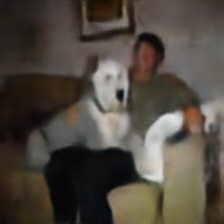

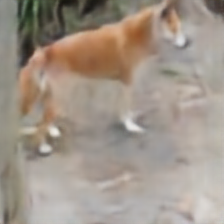

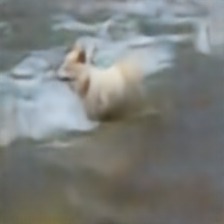

In [7]:

test_dl = ds.get_dataloader_unsliced(3, 'train')
num = 3
for sample in test_dl:
    test(model, atk, sample)
    num -= 1
    if num == 0:
        break

In [11]:
import os
import sys

sys.path.append(os.path.abspath('../..'))

from sfl.utils.exp import get_dataset, get_tokenizer

tok = get_tokenizer('gpt2-large')
tok.pad_token = tok.eos_token
data = get_dataset('piqa',tok,[])
dl = data.get_dataloader_unsliced(10,'test',1.0)

/root/miniconda3/envs/sfl/lib/python3.11/site-packages/datasets/load.py:926: FutureWarning: The repository for piqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /root/autodl-tmp/sfl/datasets/piqa/piqa.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [12]:
for batch in dl:
    print(batch)
    break

{'input_ids': tensor([[21017, 18233,    25,  1374,   284,  8335, 15317, 12656,   329,  2702,
          1586,    30,   198, 21017, 28186,    25,   797,   321,   262,  2641,
           286,  1123, 12656,   351,   257,  6503, 14093,    11,   788,  3424,
           262,  2354,   286,   262, 12656,   351,  7771, 25749,   393,  6450,
          3348,   290,   788,  4174, 28462,   284,   262, 12656, 16649,   284,
           307,   285,   515,   788, 25432,    13, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256],
        [21017, 18233,    25,  1675,  1037,   534,  3632, 12377,  1321,   618,
         11065,    11,   198, 21017, 28186,    25,   423,   257,  6508,   286,
          6099,   393,   734,   981, 11065,    13, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256